# Stock Prediction Project

In [1]:
!wget -c https://raw.githubusercontent.com/udacity/deep-learning-v2-pytorch/master/intro-to-pytorch/helper.py

from __future__ import print_function
import tensorflow as tf


from tensorflow.keras.callbacks import ModelCheckpoint, LambdaCallback

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv1D, Conv2D, Dropout, Masking,LSTM, MaxPooling2D
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.utils import get_file
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import random
import sys
import io
import datetime
import os
import pandas as pd
from sklearn.model_selection import train_test_split

from tensorflow.keras.utils import plot_model
import IPython

--2020-12-08 04:27:59--  https://raw.githubusercontent.com/udacity/deep-learning-v2-pytorch/master/intro-to-pytorch/helper.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 416 Range Not Satisfiable

    The file is already fully retrieved; nothing to do.



In [2]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

# Reload all modules imported with %aimport
%load_ext autoreload
%autoreload 1


In [3]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


# Baseline Model

- In this model, we will only use the return of AAPL to predict the next element of a sequence to get an intuition of the project.
- Returns are calculated on adjusted return, since there were several split for Apple stock, which may not be goof for predicting.
- Performance measure in this model is mean square error.


## Step A: Get the Data

In [4]:
# Data directory
data=pd.read_csv('gdrive/My Drive/Data/train/AAPL.csv')
#Add return column to the data sets
data["Return"]=data["Adj Close"].pct_change()

n_samples, n_attrs = data.shape
print("Date shape: ", data.shape)

Date shape:  (4277, 10)


In [5]:
data

,Dt,Adj Close,Close,Div,Factor,High,Low,Open,Volume,Return
0,2000-01-03,3.4785,111.938,0.0,1.0,112.5000,101.688,104.8750,133949200.0,NaN
1,2000-01-04,3.1852,102.500,0.0,1.0,110.6250,101.188,108.2500,128094400.0,-0.084318
2,2000-01-05,3.2318,104.000,0.0,1.0,110.5630,103.000,103.7500,194580400.0,0.014630
3,2000-01-06,2.9521,95.000,0.0,1.0,107.0000,95.000,106.1183,191993200.0,-0.086546
4,2000-01-07,3.0920,99.500,0.0,1.0,101.0000,95.500,96.5000,115183600.0,0.047390
...,...,...,...,...,...,...,...,...,...,...
4272,2016-12-23,111.3073,116.520,0.0,1.0,116.5255,115.590,115.5900,14249500.0,0.001978
4273,2016-12-27,112.0142,117.260,0.0,1.0,117.8000,116.490,116.5200,18296900.0,0.006351
4274,2016-12-28,111.5366,116.760,0.0,1.0,118.0170,116.200,117.5200,20905900.0,-0.004264
4275,2016-12-29,111.5079,116.730,0.0,1.0,117.1094,116.400,116.4500,15039500.0,-0.000257


In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4277 entries, 0 to 4276
Data columns (total 10 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Dt         4277 non-null   object 
 1   Adj Close  4277 non-null   float64
 2   Close      4277 non-null   float64
 3   Div        4277 non-null   float64
 4   Factor     4277 non-null   float64
 5   High       4277 non-null   float64
 6   Low        4277 non-null   float64
 7   Open       4277 non-null   float64
 8   Volume     4277 non-null   float64
 9   Return     4276 non-null   float64
dtypes: float64(9), object(1)
memory usage: 334.3+ KB


In [7]:
#Set train and test data

train_data=np.array(data['Return'].iloc[1:3000])
train_data_mean=train_data.mean()
train_data_std=train_data.std()
train_data=(train_data-train_data_mean)/train_data_std # Scale the train data sets
X_train=[]
y_train=[]

#Get the X_train y_train, using 300 previous data to predict the next data
for i in range(300, len(train_data)):
    X_train.append(train_data[i-300:i])
    y_train.append(train_data[i])

test_data=np.array(data['Return'].iloc[3000:])
test_data=(test_data-train_data_mean)/train_data_std # Scale the test data sets as same as train data
X_test=[]
y_test=[]

#Get the X_test y_test
for i in range(300, len(test_data)):
    X_test.append(test_data[i-300:i])
    y_test.append(test_data[i])

In [8]:
X_train, y_train = np.array(X_train),  np.array(y_train)
X_test, y_test =  np.array(X_test),   np.array(y_test)
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1 ))
X_train.shape, X_test.shape
y_train.shape, y_test.shape
#There are 2699 examples in train data and 977 in test data, each example has a shape of (300,1)

((2699, 300, 1), (977, 300, 1))

((2699,), (977,))

## Step B: EDA

### Visualization

<Figure size 864x432 with 0 Axes>

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Text(0.5, 1.0, 'Distribution for AAPL Returns')

Text(0.5, 1.0, 'AAPL Return')

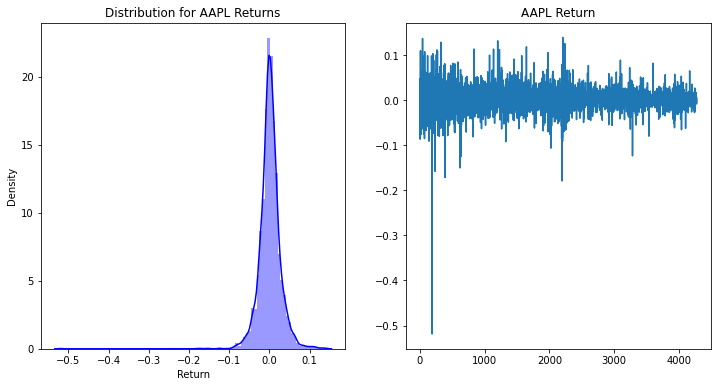

In [9]:
# Return visualization
plt.figure(figsize=(12, 6))
plt.subplot(1,2,1)
sns.distplot(data['Return'].dropna(), hist=True, kde=True, bins=100, color='blue')
plt.title('Distribution for AAPL Returns')

plt.subplot(1,2,2)
plt.plot(data['Return'])
plt.title('AAPL Return')

Text(0.5, 1.0, 'AAPL Volume')

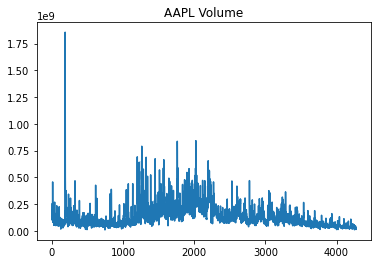

In [10]:
# Volume visualization
data['Volume'].plot()
plt.title('AAPL Volume')

Text(0.5, 1.0, 'AAPL Close')

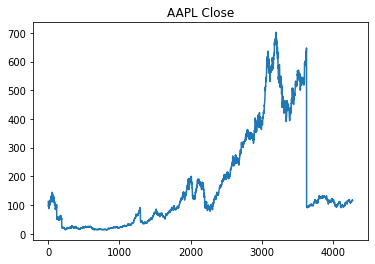

In [11]:
# Close visualization
data['Close'].plot()
plt.title('AAPL Close')

Text(0.5, 1.0, 'AAPL Adj Close')

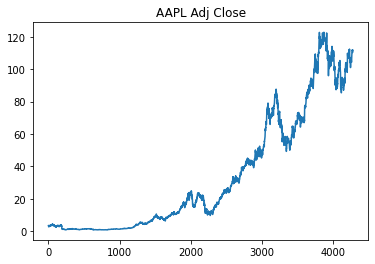

In [12]:
# Adj Close visualization
data['Adj Close'].plot()
plt.title('AAPL Adj Close')

## Step C: Prepare the data

Data was already scaled, and the data was prepared in train and test split section.



## Step D: Modelling

In [13]:
%load_ext tensorboard

import datetime

import os

logs_dir="logs/fit/"
os.makedirs( ".", exist_ok=True)

from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
log_dir= os.path.join(logs_dir, datetime.datetime.now().strftime("%Y%m%d-%H%M%S") )

tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

callbacks = tf.keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=.00005, patience=2, verbose=0, mode='auto', baseline=None, restore_best_weights=True)


In [14]:
#Construct baselne model using cnn, lstm and dense layers
def baselinemodel():
  model = Sequential()
  model.add(Conv1D(16, 3,padding='same', input_shape=(X_train.shape[1], 1,)))
  model.add(LSTM(10, activation='tanh', return_sequences=False))
  model.add(Dense(1,activation='tanh'))
  model.add(Dropout(0.2)) #Drop 0.2 of the data to prevent from overfitting
  return(model)

#Split the validation data
def valsplit(X,y):
  X_train_, X_val, y_train_, y_val = train_test_split(X, y, test_size=0.20, random_state=42)
  return(X_train_, X_val, y_train_, y_val)

X_train_, X_val, y_train_, y_val=valsplit(X_train, y_train)
model=baselinemodel()
model.compile(optimizer=RMSprop(lr=0.01), loss='mean_squared_error')

#Train the model
model.fit(X_train_, y_train_, batch_size=50, epochs=10, validation_data=(X_val, y_val),callbacks=[callbacks])

Epoch 1/10
44/44 [==============================] - 1s 29ms/step - loss: 0.7625 - val_loss: 0.7923
Epoch 2/10
44/44 [==============================] - 1s 18ms/step - loss: 0.7563 - val_loss: 0.8078
Epoch 3/10
44/44 [==============================] - 1s 18ms/step - loss: 0.7576 - val_loss: 0.7970


In [15]:
#Out of sample test
model.evaluate(X_test,y_test)

31/31 [==============================] - 0s 8ms/step - loss: 0.2569


0.2568640112876892

In [16]:
predictions = model.predict(X_test)
predictions=predictions.reshape(977)

In [17]:
test=data.iloc[3300:].loc[:].copy()
test['Return']=(test['Return']-train_data_mean)/train_data_std
test['Pred']=predictions

<Figure size 864x288 with 0 Axes>

Text(0.5, 1.0, 'True value for return')

Text(0.5, 1.0, 'Predicted value for return')

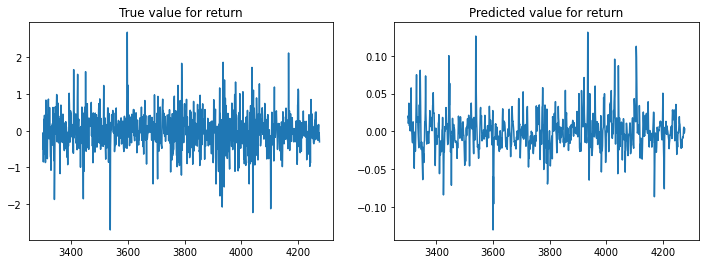

In [18]:
#Plot the true value and the predicted value
plt.figure(figsize=(12, 4))
plt.subplot(1,2,1)
plt.plot(test['Return'])
plt.title('True value for return')
plt.subplot(1,2,2)
plt.plot(test['Pred'])
plt.title('Predicted value for return')

### Results
- The out of sample loss is 0.2581, which is smaller than in sample loss.

### Error Analysis

- Found that comparing the line chart of true values and predicted values directly was hard, since they ocilliate a lot.
- Instead of only use return to predict return, we can add the other features, such as open, high, low, volume, and from different stocks and indexes.
- Since X and y are from the same datasets in this model, scaling both causing the prediction values and the y_test to be normalized, which thus cannot show the true values of return.
- The model is hardly learning, with the loss falling by a little.


# Model

In this model

- Add more features to predict return.
- Using all the previous data to predict the next return, instead of only use the previous 300 data.
- Change the model slightly to see the results.



## Step A: Get the data

- From the stocks given, I chose AAPL, FB, GOOG, INTC, MSFT and XLK, which are technology stocks and technology selected index, to predict the stock prices for AAPL.
- Drop the Div and Factor column since technology companies usually do not distribute dividend, and Factor column is all zero for AAPL.



In [19]:
# Get data and drop div and factor
tech_list=["AAPL","FB","GOOG","INTC","MSFT","XLK"]
dateAttr='Dt'
globals()["AAPL"] = pd.read_csv('gdrive/My Drive/Data/train/AAPL.csv',index_col=dateAttr).drop(columns=['Div','Factor'])
globals()["FB"] = pd.read_csv('gdrive/My Drive/Data/train/FB.csv',index_col=dateAttr).drop(columns=['Div','Factor'])
globals()["GOOG"] = pd.read_csv('gdrive/My Drive/Data/train/GOOG.csv',index_col=dateAttr).drop(columns=['Div','Factor'])
globals()["INTC"] = pd.read_csv('gdrive/My Drive/Data/train/INTC.csv',index_col=dateAttr).drop(columns=['Div','Factor'])
globals()["MSFT"] = pd.read_csv('gdrive/My Drive/Data/train/MSFT.csv',index_col=dateAttr).drop(columns=['Div','Factor'])
globals()["XLK"] = pd.read_csv('gdrive/My Drive/Data/train/XLK.csv',index_col=dateAttr).drop(columns=['Div','Factor'])


In [20]:
#Add company name, and get df which contains all the stock features
company_list = [AAPL, FB, GOOG, INTC, MSFT, XLK]
company_name = ["AAPL","FB","GOOG","INTC","MSFT","XLK"]

for company, com_name in zip(company_list, company_name):
    company["company_name"] = com_name
    
df = pd.concat(company_list, axis=1)

In [21]:
# Have a look at the data
df

,Adj Close,Close,High,Low,Open,Volume,company_name,Adj Close,Close,High,Low,Open,Volume,company_name,Adj Close,Close,High,Low,Open,Volume,company_name,Adj Close,Close,High,Low,Open,Volume,company_name,Adj Close,Close,High,Low,Open,Volume,company_name,Adj Close,Close,High,Low,Open,Volume,company_name
Dt,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2000-01-03,3.4785,111.938,112.5000,101.688,104.8750,133949200.0,AAPL,NaN,NaN,NaN,NaN,NaN,NaN,FB,NaN,NaN,NaN,NaN,NaN,NaN,GOOG,28.0137,43.500,43.6880,41.625,41.633,57710200.0,INTC,37.6233,116.563,118.6250,112.000,117.375,53228400.0,MSFT,43.6306,55.438,55.625,53.5000,55.625,938100.0,XLK
2000-01-04,3.1852,102.500,110.6250,101.188,108.2500,128094400.0,AAPL,NaN,NaN,NaN,NaN,NaN,NaN,FB,NaN,NaN,NaN,NaN,NaN,NaN,GOOG,26.7056,41.469,43.9380,41.125,42.719,51019600.0,INTC,36.3524,112.625,117.1250,112.250,113.563,54119000.0,MSFT,41.4171,52.625,54.750,52.3130,54.000,545500.0,XLK
2000-01-05,3.2318,104.000,110.5630,103.000,103.7500,194580400.0,AAPL,NaN,NaN,NaN,NaN,NaN,NaN,FB,NaN,NaN,NaN,NaN,NaN,NaN,GOOG,26.9270,41.813,42.9345,40.250,41.500,52389000.0,INTC,36.7357,113.813,116.3750,109.375,111.125,64059600.0,MSFT,40.8022,51.844,53.063,50.1250,51.750,1906000.0,XLK
2000-01-06,2.9521,95.000,107.0000,95.000,106.1183,191993200.0,AAPL,NaN,NaN,NaN,NaN,NaN,NaN,FB,NaN,NaN,NaN,NaN,NaN,NaN,GOOG,25.3572,39.375,41.6880,39.094,40.875,55171200.0,INTC,35.5051,110.000,113.8750,108.375,112.188,54976600.0,MSFT,39.4496,50.125,52.094,49.6250,51.250,1670000.0,XLK
2000-01-07,3.0920,99.500,101.0000,95.500,96.5000,115183600.0,AAPL,NaN,NaN,NaN,NaN,NaN,NaN,FB,NaN,NaN,NaN,NaN,NaN,NaN,GOOG,26.4037,41.000,41.0000,38.688,38.750,41096400.0,INTC,35.9691,111.438,112.2500,107.313,108.625,62013600.0,MSFT,40.1382,51.000,51.000,49.1263,49.625,686000.0,XLK
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2016-12-23,111.3073,116.520,116.5255,115.590,115.5900,14249500.0,AAPL,117.27,117.27,117.560,116.300,117.0000,10890000.0,FB,789.91,789.91,792.74,787.280,790.9000,623400.0,GOOG,34.2162,36.970,36.9800,36.770,36.930,6287300.0,INTC,60.1241,63.240,63.5400,62.800,63.450,12403800.0,MSFT,47.0785,48.970,48.980,48.7840,48.870,6358700.0,XLK
2016-12-27,112.0142,117.260,117.8000,116.490,116.5200,18296900.0,AAPL,118.01,118.01,118.680,116.864,116.9510,12051500.0,FB,791.55,791.55,797.86,787.657,790.6800,789100.0,GOOG,34.3088,37.070,37.3300,36.910,36.910,9033700.0,INTC,60.1621,63.280,64.0700,63.210,63.210,11763200.0,MSFT,47.2708,49.170,49.400,49.0000,49.020,6840700.0,XLK
2016-12-28,111.5366,116.760,118.0170,116.200,117.5200,20905900.0,AAPL,116.92,116.92,118.250,116.650,118.1956,12087400.0,FB,785.05,785.05,794.23,783.200,793.7000,1153800.0,GOOG,33.9015,36.630,37.2000,36.580,37.100,12868600.0,INTC,59.8864,62.990,63.4009,62.830,63.400,14653300.0,MSFT,46.8478,48.730,49.295,48.7100,49.230,7777600.0,XLK


In [22]:
#Drop the company_name columns
df=df.drop(columns='company_name')
#Drop na
df=df.dropna()
df

,Adj Close,Close,High,Low,Open,Volume,Adj Close,Close,High,Low,Open,Volume,Adj Close,Close,High,Low,Open,Volume,Adj Close,Close,High,Low,Open,Volume,Adj Close,Close,High,Low,Open,Volume,Adj Close,Close,High,Low,Open,Volume
Dt,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2012-05-18,65.9263,530.38,543.4100,522.18,533.9600,183073100.0,38.23,38.232,45.000,38.000,42.0500,573576400.0,299.0790,299.0790,315.0292,297.2359,311.3829,11991700.0,20.7380,26.07,26.5700,26.05,26.2400,43444900.0,24.5447,29.27,29.8100,29.17,29.7924,56205300.0,24.1967,27.47,27.930,27.4100,27.8390,12598100.0
2012-05-21,69.7672,561.28,561.5400,534.05,534.5000,157776500.0,34.03,34.030,36.660,33.000,36.5300,168192700.0,305.9084,305.9084,306.6954,298.8797,299.1338,6173800.0,20.8016,26.15,26.1900,25.68,26.0600,41389400.0,24.9472,29.75,29.7900,29.06,29.1000,38787900.0,24.7956,28.15,28.160,27.4700,27.5300,8552200.0
2012-05-22,69.2314,556.97,573.8800,552.58,569.5500,173717600.0,31.00,31.000,33.590,30.940,32.6100,101786600.0,299.2782,299.2782,305.7589,296.8872,305.5746,6126600.0,20.7062,26.03,26.2800,25.78,26.2688,46037700.0,24.9556,29.76,29.8800,29.50,29.6900,39504900.0,24.7164,28.06,28.315,27.9000,28.2400,7814300.0
2012-05-23,70.9207,570.56,572.8000,553.23,557.5000,146224400.0,32.00,32.000,32.500,31.360,31.3700,73600000.0,303.5921,303.5921,303.6618,297.4451,299.7016,6379900.0,20.2368,25.44,25.5111,24.92,25.4700,61969600.0,24.4105,29.11,29.4000,28.64,29.3500,65171000.0,24.7428,28.09,28.170,27.5895,27.8500,8718700.0
2012-05-24,70.2693,565.32,576.5069,561.23,575.8700,124057500.0,33.03,33.030,33.210,31.770,32.9500,50237200.0,300.7029,300.7029,304.8175,298.3168,303.4426,3796600.0,20.4039,25.65,25.7800,25.31,25.5700,37129200.0,24.3770,29.07,29.3000,28.76,29.1600,52575000.0,24.6019,27.93,28.180,27.7200,28.1687,8300400.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2016-12-23,111.3073,116.52,116.5255,115.59,115.5900,14249500.0,117.27,117.270,117.560,116.300,117.0000,10890000.0,789.9100,789.9100,792.7400,787.2800,790.9000,623400.0,34.2162,36.97,36.9800,36.77,36.9300,6287300.0,60.1241,63.24,63.5400,62.80,63.4500,12403800.0,47.0785,48.97,48.980,48.7840,48.8700,6358700.0
2016-12-27,112.0142,117.26,117.8000,116.49,116.5200,18296900.0,118.01,118.010,118.680,116.864,116.9510,12051500.0,791.5500,791.5500,797.8600,787.6570,790.6800,789100.0,34.3088,37.07,37.3300,36.91,36.9100,9033700.0,60.1621,63.28,64.0700,63.21,63.2100,11763200.0,47.2708,49.17,49.400,49.0000,49.0200,6840700.0
2016-12-28,111.5366,116.76,118.0170,116.20,117.5200,20905900.0,116.92,116.920,118.250,116.650,118.1956,12087400.0,785.0500,785.0500,794.2300,783.2000,793.7000,1153800.0,33.9015,36.63,37.2000,36.58,37.1000,12868600.0,59.8864,62.99,63.4009,62.83,63.4000,14653300.0,46.8478,48.73,49.295,48.7100,49.2300,7777600.0


Notice there are too much NaN in GOOG and FB. Discard these two stocks.

In [23]:
company_list = [AAPL, INTC, MSFT, XLK]
company_name = ["AAPL","INTC","MSFT","XLK"]
tech_list=["AAPL","INTC","MSFT","XLK"]

for company, com_name in zip(company_list, company_name):
    company["company_name"] = com_name
    
df = pd.concat(company_list, axis=1)

In [24]:
df=df.drop(columns='company_name')
df=df.dropna()
df

,Adj Close,Close,High,Low,Open,Volume,Adj Close,Close,High,Low,Open,Volume,Adj Close,Close,High,Low,Open,Volume,Adj Close,Close,High,Low,Open,Volume
Dt,,,,,,,,,,,,,,,,,,,,,,,,
2000-01-03,3.4785,111.938,112.5000,101.688,104.8750,133949200.0,28.0137,43.500,43.6880,41.625,41.633,57710200.0,37.6233,116.563,118.6250,112.000,117.375,53228400.0,43.6306,55.438,55.625,53.5000,55.625,938100.0
2000-01-04,3.1852,102.500,110.6250,101.188,108.2500,128094400.0,26.7056,41.469,43.9380,41.125,42.719,51019600.0,36.3524,112.625,117.1250,112.250,113.563,54119000.0,41.4171,52.625,54.750,52.3130,54.000,545500.0
2000-01-05,3.2318,104.000,110.5630,103.000,103.7500,194580400.0,26.9270,41.813,42.9345,40.250,41.500,52389000.0,36.7357,113.813,116.3750,109.375,111.125,64059600.0,40.8022,51.844,53.063,50.1250,51.750,1906000.0
2000-01-06,2.9521,95.000,107.0000,95.000,106.1183,191993200.0,25.3572,39.375,41.6880,39.094,40.875,55171200.0,35.5051,110.000,113.8750,108.375,112.188,54976600.0,39.4496,50.125,52.094,49.6250,51.250,1670000.0
2000-01-07,3.0920,99.500,101.0000,95.500,96.5000,115183600.0,26.4037,41.000,41.0000,38.688,38.750,41096400.0,35.9691,111.438,112.2500,107.313,108.625,62013600.0,40.1382,51.000,51.000,49.1263,49.625,686000.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2016-12-23,111.3073,116.520,116.5255,115.590,115.5900,14249500.0,34.2162,36.970,36.9800,36.770,36.930,6287300.0,60.1241,63.240,63.5400,62.800,63.450,12403800.0,47.0785,48.970,48.980,48.7840,48.870,6358700.0
2016-12-27,112.0142,117.260,117.8000,116.490,116.5200,18296900.0,34.3088,37.070,37.3300,36.910,36.910,9033700.0,60.1621,63.280,64.0700,63.210,63.210,11763200.0,47.2708,49.170,49.400,49.0000,49.020,6840700.0
2016-12-28,111.5366,116.760,118.0170,116.200,117.5200,20905900.0,33.9015,36.630,37.2000,36.580,37.100,12868600.0,59.8864,62.990,63.4009,62.830,63.400,14653300.0,46.8478,48.730,49.295,48.7100,49.230,7777600.0


In [25]:
AAPL.describe()

,Adj Close,Close,High,Low,Open,Volume
count,4277.000000,4277.000000,4277.000000,4277.000000,4277.000000,4.277000e+03
mean,34.065846,170.450354,172.424040,168.407568,170.528689,1.299660e+08
std,36.698987,173.484604,174.989551,171.934671,173.604272,9.970883e+07
min,0.815400,13.120000,13.190000,12.720000,12.990000,9.835000e+06
25%,3.115300,39.759000,40.260000,39.030000,39.530000,6.363350e+07
50%,16.948300,106.745000,108.360000,105.200000,106.959000,1.016484e+08
75%,62.413600,222.250000,224.980000,217.890000,220.010000,1.679636e+08
max,122.771400,702.100000,705.070000,699.570000,702.410000,1.855410e+09


In [26]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 4277 entries, 2000-01-03 to 2016-12-30
Data columns (total 24 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Adj Close  4277 non-null   float64
 1   Close      4277 non-null   float64
 2   High       4277 non-null   float64
 3   Low        4277 non-null   float64
 4   Open       4277 non-null   float64
 5   Volume     4277 non-null   float64
 6   Adj Close  4277 non-null   float64
 7   Close      4277 non-null   float64
 8   High       4277 non-null   float64
 9   Low        4277 non-null   float64
 10  Open       4277 non-null   float64
 11  Volume     4277 non-null   float64
 12  Adj Close  4277 non-null   float64
 13  Close      4277 non-null   float64
 14  High       4277 non-null   float64
 15  Low        4277 non-null   float64
 16  Open       4277 non-null   float64
 17  Volume     4277 non-null   float64
 18  Adj Close  4277 non-null   float64
 19  Close      4277 non-null   float64
 20

### Scale the data & Train test split

Since each example has different length, we scale the data first.

In [27]:
#Get X and y
X=df.copy()
y=df.iloc[:,0].pct_change()

#Set 80% of data to be the train data
train_data_len=int(np.ceil( X.shape[0] * .8 ))
test_data_len=X.shape[0]-train_data_len

train_data=X.iloc[:train_data_len,:]
test_data=X.iloc[train_data_len:,:]
train_data_mean=train_data.mean()
train_data_std=train_data.std()
train_data=(train_data-train_data_mean)/train_data_std # Scale the train data sets
test_data=(test_data-train_data_mean)/train_data_std # Scale the test data sets as same as train data

# Set train test target
y_train=y.iloc[300:train_data_len]
y_test=y.iloc[train_data_len+300:]

#Set train test features
X_train=[]
#Get the sequence of features for every target data
for i in range(300, train_data.shape[0]):
  n=train_data.iloc[:i,:].values.tolist()
  X_train.append(n)

X_test=[]
#Get the X_test y_test
for i in range(300, test_data.shape[0]):
  m=test_data.iloc[:i,:].values.tolist()
  X_test.append(m)

X_train, X_test = np.array(X_train), np.array(X_test)

X_train.shape, X_test.shape
y_train.shape, y_test.shape

((3122,), (555,))

((3122,), (555,))

## Step B: EDA

In [28]:
def plotstock(features):
  plt.figure(figsize=(14,112))
  plt.subplots_adjust(top=1.25, bottom=1.2)

  for i, company in enumerate(company_list, 1):
      plt.subplot(2, 2, i)
      company[features].plot()
      plt.ylabel(features)
      plt.xlabel(None)
      plt.title(f"{tech_list[i - 1]}")
  return()

()

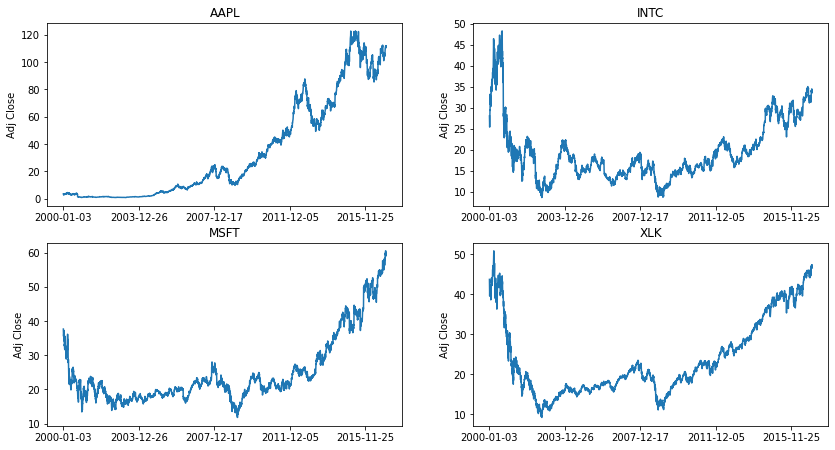

In [29]:
#Plot adjusted close
plotstock('Adj Close')

()

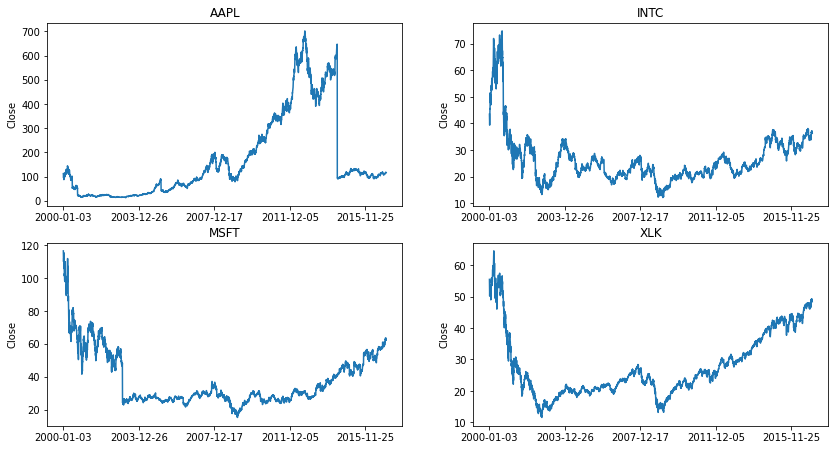

In [30]:
#Plot Close
plotstock('Close')

Text(0.5, 1.0, 'AAPL')

Text(0.5, 1.0, 'INTC')

Text(0.5, 1.0, 'MSFT')

Text(0.5, 1.0, 'XLK')

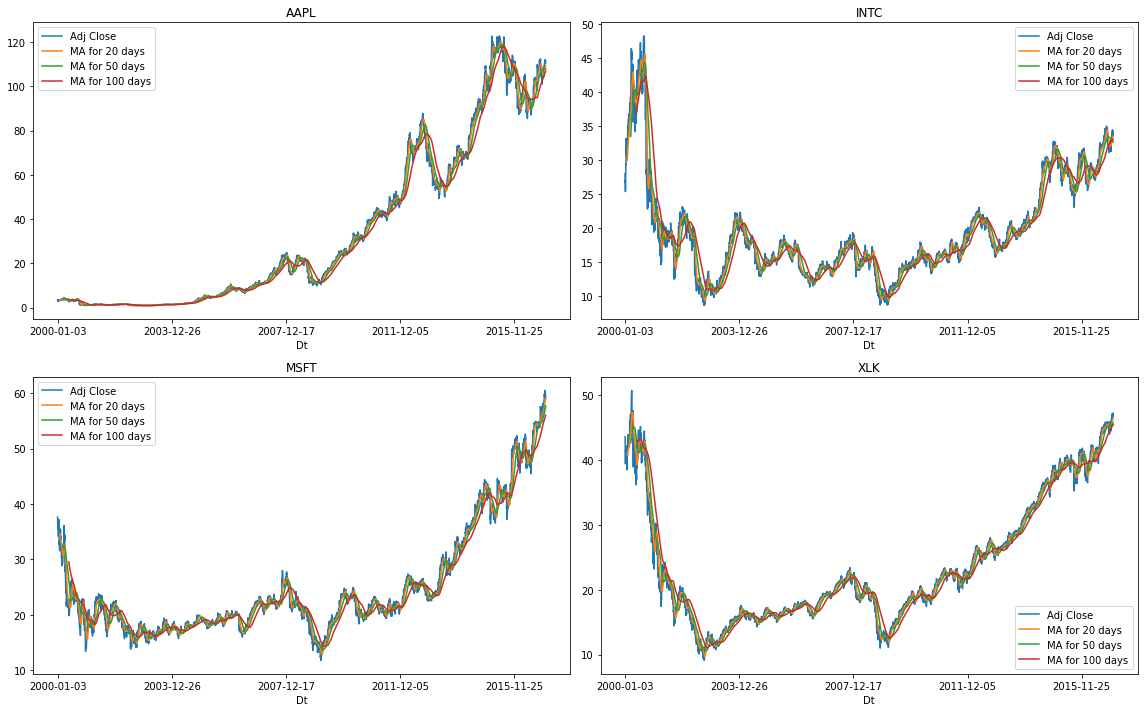

In [31]:
#Moving Average Plot
ma_day = [20, 50, 100]

for ma in ma_day:
    for company in company_list:
        column_name = f"MA for {ma} days"
        company[column_name] = company['Adj Close'].rolling(ma).mean()

fig, axes = plt.subplots(nrows=2, ncols=2)
fig.set_figheight(10)
fig.set_figwidth(16)

AAPL[['Adj Close', 'MA for 20 days', 'MA for 50 days', 'MA for 100 days']].plot(ax=axes[0,0])
axes[0,0].set_title('AAPL')

INTC[['Adj Close', 'MA for 20 days', 'MA for 50 days', 'MA for 100 days']].plot(ax=axes[0,1])
axes[0,1].set_title('INTC')

MSFT[['Adj Close', 'MA for 20 days', 'MA for 50 days', 'MA for 100 days']].plot(ax=axes[1,0])
axes[1,0].set_title('MSFT')

XLK[['Adj Close', 'MA for 20 days', 'MA for 50 days', 'MA for 100 days']].plot(ax=axes[1,1])
axes[1,1].set_title('XLK')

fig.tight_layout()


Text(0.5, 1.0, 'AAPL')

Text(0.5, 1.0, 'INTC')

Text(0.5, 1.0, 'MSFT')

Text(0.5, 1.0, 'XLK')

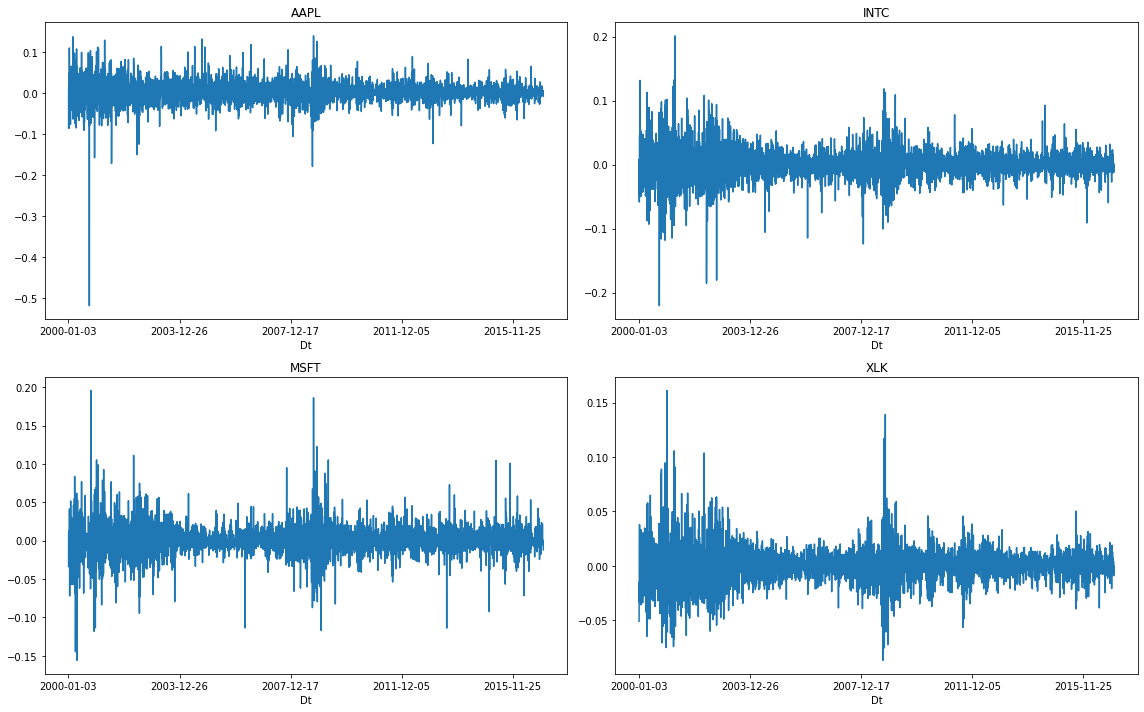

In [32]:
# Daily return
for company in company_list:
    company['Daily Return'] = company['Adj Close'].pct_change()

fig, axes = plt.subplots(nrows=2, ncols=2)
fig.set_figheight(10)
fig.set_figwidth(16)

AAPL['Daily Return'].plot(ax=axes[0,0])
axes[0,0].set_title('AAPL')

INTC['Daily Return'].plot(ax=axes[0,1])
axes[0,1].set_title('INTC')

MSFT['Daily Return'].plot(ax=axes[1,0])
axes[1,0].set_title('MSFT')

XLK['Daily Return'].plot(ax=axes[1,1])
axes[1,1].set_title('XLK')

fig.tight_layout()


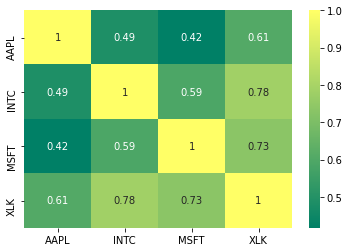

In [33]:
#Visualize the correlations between features of stocks
def extractfeatures(feature):
  tech=pd.concat([AAPL[feature],INTC[feature],MSFT[feature],XLK[feature]],axis=1)
  tech=tech.dropna()
  tech.columns=company_name
  return(tech)

dailyreturns=extractfeatures('Daily Return')
sns.heatmap(dailyreturns.corr(), annot=True, cmap='summer')

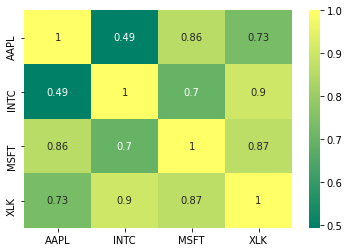

In [34]:
adjclose=extractfeatures('Adj Close')
sns.heatmap(adjclose.corr(), annot=True, cmap='summer')

We can see from the correlation plot that although the correlations between returns are not strong, the correlations between adjusted close are relatively strong. Thus, predicting adj close might be a good idea.

## Step C: Prepare the sequence

Since every example's length is different, add zero until the legth reaches the maximum.

In [35]:
def preprocess(X):
  X_lastelementlen=len(X[-1])
  X=tf.keras.preprocessing.sequence.pad_sequences(X,maxlen=X_lastelementlen,padding='post')
  return(X)

X_train=preprocess(X_train)
X_test=preprocess(X_test)

In [36]:
# See the shape 
X_train.shape, X_test.shape

((3122, 3421, 24), (555, 854, 24))

## Step C: Modelling

### Model 0

In [46]:
def model_0():
  model = Sequential()
  model.add(Masking(mask_value=0,input_shape=X_train[-1].shape))#Skip time steps with value of zero
  model.add(LSTM(20, activation='tanh', return_sequences=False))
  model.add(Dense(1,activation='tanh'))
  model.add(Dropout(0.2))
  return(model)

callbacks = tf.keras.callbacks.EarlyStopping(monitor='loss', min_delta=.00005, patience=2, verbose=0, mode='auto', baseline=None, restore_best_weights=True)

model_0=model_0()
model_0.compile(optimizer=RMSprop(lr=0.01), loss='mean_squared_error')
model_0.fit(X_train, y_train, batch_size=100, epochs=10,callbacks=[callbacks])

Epoch 1/10
32/32 [==============================] - 231s 7s/step - loss: 0.0138
Epoch 2/10
32/32 [==============================] - 231s 7s/step - loss: 0.0028
Epoch 3/10
32/32 [==============================] - 229s 7s/step - loss: 0.0020
Epoch 4/10
32/32 [==============================] - 229s 7s/step - loss: 0.0013
Epoch 5/10
32/32 [==============================] - 230s 7s/step - loss: 0.0011
Epoch 6/10
32/32 [==============================] - 228s 7s/step - loss: 9.4860e-04
Epoch 7/10
32/32 [==============================] - 228s 7s/step - loss: 8.0663e-04
Epoch 8/10
32/32 [==============================] - 229s 7s/step - loss: 7.4953e-04
Epoch 9/10
32/32 [==============================] - 228s 7s/step - loss: 7.2258e-04
Epoch 10/10
32/32 [==============================] - 228s 7s/step - loss: 7.1345e-04


In [47]:
#Out of sample test
model_0.evaluate(X_test,y_test)

18/18 [==============================] - 0s 16ms/step - loss: 0.0121


0.012095212936401367

In [48]:
y_pred = model_0.predict(X_test)
y_pred=y_pred.reshape(555)

In [49]:
y_pred


array([ 0.12307434,  0.12701735,  0.09629999,  0.09929897, -0.00174616,
        0.16140404,  0.1124144 ,  0.1169304 ,  0.07760195,  0.10729477,
        0.10335638,  0.10854259,  0.1045492 ,  0.10839787,  0.10868203,
        0.10943803,  0.11006623,  0.11077668,  0.1060045 ,  0.1015996 ,
        0.10781089,  0.10685042,  0.10096414,  0.12401594,  0.11912606,
        0.13055186,  0.14289856,  0.13985188,  0.13070266,  0.12875663,
        0.11430652,  0.14415103,  0.09595206,  0.07953989,  0.07848401,
        0.06103887,  0.0438544 ,  0.01756965,  0.00746842,  0.01641853,
       -0.00399624, -0.0252877 , -0.00402421,  0.0086021 ,  0.01651056,
        0.05462757,  0.07217483,  0.06691386,  0.06414735,  0.06269614,
        0.02321824,  0.0025962 ,  0.01773153,  0.01370379,  0.00334857,
        0.02874518,  0.02561842,  0.03796056,  0.03040609,  0.00757003,
        0.02311877,  0.01338272, -0.02949039, -0.00394335,  0.00759219,
        0.02423616,  0.02123803,  0.01448466,  0.00062469,  0.03

<Figure size 864x288 with 0 Axes>

Text(0.5, 1.0, 'True value for return')

Text(0.5, 1.0, 'Predicted value for return')

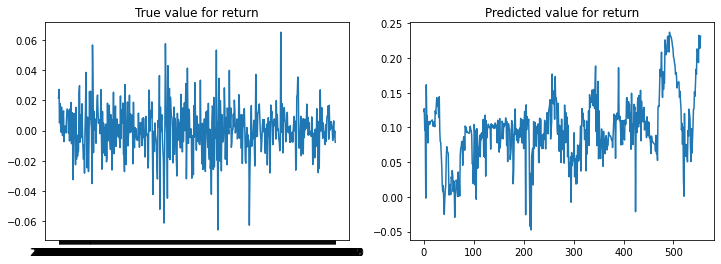

In [50]:
#Plot the true value and the predicted value
plt.figure(figsize=(12, 4))
plt.subplot(1,2,1)
plt.plot(y_test)
plt.title('True value for return')
plt.subplot(1,2,2)
plt.plot(y_pred)
plt.title('Predicted value for return')

- Trayning time is so long.
- Out of sample performance is not very good.
- In sample loss is relatively good.

### Model 1 - Add a cnn layer


In [51]:
def model_1():
  model = Sequential()
  model.add(Masking(mask_value=0,input_shape=X_train[-1].shape))
  model.add(Conv1D(16, 3,padding='same'))
  model.add(LSTM(10, activation='tanh', return_sequences=False))
  model.add(Dense(1,activation='tanh'))
  model.add(Dropout(0.2))
  return(model)

model_1=model_1()
model_1.compile(optimizer=RMSprop(lr=0.01), loss='mean_squared_error')
model_1.fit(X_train, y_train, batch_size=100, epochs=10,callbacks=[callbacks])

Epoch 1/10
32/32 [==============================] - 5s 153ms/step - loss: 0.0052
Epoch 2/10
32/32 [==============================] - 5s 152ms/step - loss: 0.0011
Epoch 3/10
32/32 [==============================] - 5s 152ms/step - loss: 9.6412e-04
Epoch 4/10
32/32 [==============================] - 5s 151ms/step - loss: 8.4022e-04
Epoch 5/10
32/32 [==============================] - 5s 152ms/step - loss: 7.2779e-04
Epoch 6/10
32/32 [==============================] - 5s 151ms/step - loss: 7.1801e-04
Epoch 7/10
32/32 [==============================] - 5s 152ms/step - loss: 6.9881e-04


In [52]:
model_1.evaluate(X_test,y_test)

18/18 [==============================] - 0s 20ms/step - loss: 7.2180e-04


0.0007218009559437633

In [53]:
y_pred = model_1.predict(X_test)
y_pred=y_pred.reshape(555)
y_pred

array([ 0.02214693,  0.02214693,  0.02214693,  0.02214693,  0.02214693,
        0.02214693,  0.02214693,  0.02214693,  0.02214693,  0.02214693,
        0.02214693,  0.02214693,  0.02214693,  0.02214693,  0.02214693,
        0.02214693,  0.02214693,  0.02214693,  0.02214693,  0.02214693,
        0.02214693,  0.02214693,  0.02214693,  0.02214693,  0.02214693,
        0.02214693,  0.02214693,  0.02214693,  0.02214693,  0.02214693,
        0.02214693,  0.02214693,  0.02214693,  0.02214693,  0.02214693,
        0.02214693,  0.02214693,  0.02214693,  0.02214693,  0.02214693,
        0.02214693,  0.02214693,  0.02214693,  0.02214693,  0.02214693,
        0.02214693,  0.02214693,  0.02214693,  0.02214693,  0.02214693,
        0.02214693,  0.02214693,  0.02214693,  0.02214693,  0.02214693,
        0.02214693,  0.02214693,  0.02214693,  0.02214693,  0.02214693,
        0.02214693,  0.02214693,  0.02214693,  0.02214693,  0.02214693,
        0.02214693,  0.02214693,  0.02214693,  0.02214693,  0.02

<Figure size 864x288 with 0 Axes>

Text(0.5, 1.0, 'True value for return')

Text(0.5, 1.0, 'Predicted value for return')

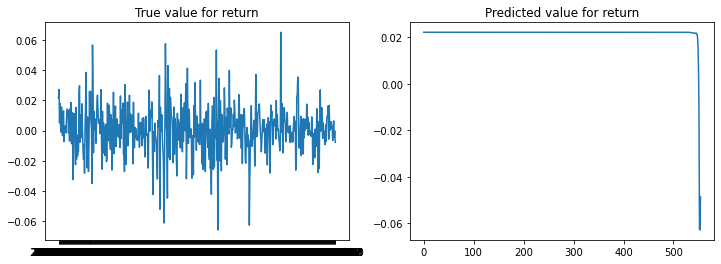

In [54]:
plt.figure(figsize=(12, 4))
plt.subplot(1,2,1)
plt.plot(y_test)
plt.title('True value for return')
plt.subplot(1,2,2)
plt.plot(y_pred)
plt.title('Predicted value for return')

- Prediction results are all the same
- Out of sample loss is better.

### Model 2 - Add two cnn layers

In [55]:
def model_2():
  model = Sequential()
  model.add(Masking(mask_value=0,input_shape=X_train[-1].shape))
  model.add(Conv1D(64, 3, activation='relu',padding='same'))
  model.add(Conv1D(32, 3, activation='relu',padding='same'))
  model.add(LSTM(10, activation='tanh', return_sequences=False))
  model.add(Dense(1,activation='relu'))
  model.add(Dropout(0.2))
  return(model)

model_2=model_2()
model_2.compile(optimizer=RMSprop(lr=0.01), loss='mean_squared_error')
model_2.fit(X_train, y_train, batch_size=100, epochs=10,callbacks=[callbacks])

Epoch 1/10
32/32 [==============================] - 5s 160ms/step - loss: 7.7538e-04
Epoch 2/10
32/32 [==============================] - 5s 160ms/step - loss: 6.4589e-04
Epoch 3/10
32/32 [==============================] - 5s 159ms/step - loss: 6.4589e-04
Epoch 4/10
32/32 [==============================] - 5s 161ms/step - loss: 6.4589e-04


In [56]:
model_2.evaluate(X_test,y_test)

18/18 [==============================] - 0s 20ms/step - loss: 2.4295e-04


0.00024295492039527744

In [57]:
y_pred = model_2.predict(X_test)
y_pred=y_pred.reshape(555)
y_pred

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0.

- Predicted results are all zero

Also tried adding lstm layers, but the calculating time was so long.

### Error Analysis

- The out of sample loss for models are samll, but the returns either shifted from 0 or were all the same value or even zero.
- The probable reasons for that might be the orginal returns are concentrated around the zero, so that the predctions of all zero values can give small loss, without obvious trend for return.
- We can further change the features, such as using synthetical features like moving average to model.

# My Model

In [64]:
import os
from tensorflow.keras.models import load_model

modelName = "final_model"
model_path = os.path.join('.', modelName)

def saveModel(model, model_path): 
    try:
        os.makedirs(model_path)
    except OSError:
        print("Directory {dir:s} already exists, files will be over-written.".format(dir=model_path))
        
    # Save JSON config to disk
    json_config = model.to_json()
    with open(os.path.join(model_path, 'config.json'), 'w') as json_file:
        json_file.write(json_config)
    # Save weights to disk
    model.save_weights(os.path.join(model_path, 'weights.h5'))
    
    print("Model saved in directory {dir:s}; create an archive of this directory and submit with your assignment.".format(dir=model_path))
    
def loadModel(model_path):
    # Reload the model from the 2 files we saved
    with open(os.path.join(model_path, 'config.json')) as json_file:
        json_config = json_file.read()
    model = tf.keras.models.model_from_json(json_config)
    model.load_weights(os.path.join(model_path, 'weights.h5'))
    
    return model

def MyModel(test_dir, model_path):
    # YOU MAY NOT change model after this statement !
    model = loadModel(model_path)
    
    # It should run model to create an array of predictions; we initialize it to the empty array for convenience
    predictions = []
    
    # We need to match your array of predictions with the examples you are predicting
    # The array below (ids) should have a one-to-one correspondence and identify the example your are predicting
    # For Bankruptcy: the Id column
    # For Stock prediction: the date on which you are making a prediction
    ids = []
    
    # YOUR CODE GOES HERE
    #Get data
    dateAttr='Dt'
    globals()["AAPL"] = pd.read_csv(os.path.join(test_dir, 'AAPL.csv'),index_col=dateAttr).drop(columns=['Div','Factor'])
    globals()["INTC"] = pd.read_csv(os.path.join(test_dir, 'INTC.csv'),index_col=dateAttr).drop(columns=['Div','Factor'])
    globals()["MSFT"] = pd.read_csv(os.path.join(test_dir, 'MSFT.csv'),index_col=dateAttr).drop(columns=['Div','Factor'])
    globals()["XLK"] = pd.read_csv(os.path.join(test_dir, 'XLK.csv'),index_col=dateAttr).drop(columns=['Div','Factor'])
    company_list = [AAPL, INTC, MSFT, XLK]
    company_name = ["AAPL","INTC","MSFT","XLK"]
    df = pd.concat(company_list, axis=1)
    df=df.dropna()

    #Prepare data
    X=df.copy()
    y=df.iloc[:,0].pct_change()
    X=(X-train_data_mean)/train_data_std#Scale using train datasets

    X_holdout=[]
    for i in range(200):
      X_holdout.append(X.iloc[:(X.shape[0]-200+i),:].values.tolist())
    
    X_holdout=np.array(X_holdout)
    X_holdout=preprocess(X_holdout)
  
    y_holdout=y.iloc[(y.shape[0]-200):]

    #Predict
    predictions=model.predict(X_holdout)
    ids=y_holdout.index
    return predictions, ids

# Assign to variable my_model the model that is your final model (the one  you will be evaluated on)
my_model = model_0 # CHANGE None to your model !

saveModel(my_model, model_path)

Directory ./final_model already exists, files will be over-written.
Model saved in directory ./final_model; create an archive of this directory and submit with your assignment.


In [65]:
holdout_dir = os.path.join("gdrive", "My Drive", "Data", "holdout")
predicts = MyModel(holdout_dir, model_path)

In [70]:
print("Done")

Done
